# Summary
In this demo, we're going to find out some relationships between the road network and traffic accidents in Maryland. Functions and classes in `arcpy.da` module are introduced through the demo.

GitHub repo link can be retrieved as `http://links.esri.com/WorkingWithFeatureData`, or by scanning the following QR code:
<center><img src="./qrcode.png"></center>

# About Jupyter Notebook
Jupyter Notebook is a development environment (in the form of web application), that allows you to create and share documents that contain **live code, equations, visualizations and narrative text**.

This package is pre-installed in the conda environment shipped with **ArcGIS Pro 2.0** or later. For other ArcGIS Pro versions and ArcMap, follow the [install instructions](https://github.com/jibin-geoprocessing/WorkingWithFeatureData#install-jupyter-notebook) to install Jupyter Notebook.

To know more about Jupyter Notebook, check https://jupyter.org/.

# About the data
- The traffic accidents data and data dictionary can be retrieved from [Maryland Open Data Portal](https://data.maryland.gov/browse?q=Maryland+Statewide+Vehicle+Crashes&sortBy=relevance&utf8=&page=1). In this demo, we use `"Maryland Statewide Vehicle Crashes: CY2017 Quarter 4"` data.
- The road network data can be retrieved from [Maryland's GIS Data Catalog](http://data.imap.maryland.gov/datasets/maryland-annual-average-daily-traffic-annual-average-daily-traffic-sha-statewide-aadt-lines?geometry=-86.553%2C37.336%2C-67.986%2C40.331)

<center><img src="./mapview.png"></center>


# Setup
We import `arcpy` module and make some environment settings here. 

In [1]:
"""
import `arcpy` and other modules, and make some environment settings here. 
"""
import arcpy
import os
from pprint import pprint

arcpy.env.workspace = '.\\WorkingWithFeatureData.gdb'
arcpy.env.scratchWorkspace = '.\\scratch.gdb'
arcpy.env.overwriteOutput = True

# Part I: Cleaning crash data
In this part, we're going to show how to use `arcpy.da.Editor`, `arcpy.da.SearchCursor` and `arcpy.da.InsertCursor` to find out and clean invalid values in the accidents data.

In [2]:
# https://pro.arcgis.com/en/pro-app/arcpy/functions/listfields.htm
# look at the first 5 fields in the data

crash = os.path.join(arcpy.env.workspace, 'crash')
fields = arcpy.ListFields(crash)
pprint([(f.name, f.type, f.aliasName) for f in fields[:5]])

[('OBJECTID', 'OID', 'OBJECTID'),
 ('Shape', 'Geometry', 'Shape'),
 ('LIGHT_CODE', 'Double', 'LIGHT_CODE'),
 ('COUNTY_NO', 'Integer', 'COUNTY_NO'),
 ('MUNI_CODE', 'Integer', 'MUNI_CODE')]


In [4]:
"""
https://pro.arcgis.com/en/pro-app/arcpy/data-access/searchcursor-class.htm

- Checking the data using arcpy.da.SearchCursor.
- "Bad" pattern to use '*' all field names.
"""

print('####### Using for loop #######')
with arcpy.da.SearchCursor(crash, '*') as cursor:  # cursor is an iterator of tuples
    for row in cursor:
        print(row)  # print the values for all columns
        print(row[:2])  # print the values for first two columns
        break

print('\n####### Using next() #######')
with arcpy.da.SearchCursor(crash, '*') as cursor:
    # fetch the next row in cursor
    # In python 2.7, cursor.next()
    print(next(cursor))

####### Using for loop #######
(1, (-76.61431453299997, 39.413163300000065), 1.0, 3, 0, 0.0, 3, 2.0, 3, 1, 4.0, 0.0, 'MSP6732006F', 'Property Damage Crash', 6.01, datetime.datetime(2017, 12, 29, 0, 0), datetime.datetime(1899, 12, 30, 13, 17), None, 'N', 'N', 'MSP', 'UNK', 1.0, 0.0, 695, 'IS', None, 20.5, 'N', 'BALTO BELTWAY', 10.0, 'F', 'S', 45, 'MD', None, 'YORK RD', 39.4131633, -76.6143145333333)
(1, (-76.61431453299997, 39.413163300000065))

####### Using cursor.next() #######
(1, (-76.61431453299997, 39.413163300000065), 1.0, 3, 0, 0.0, 3, 2.0, 3, 1, 4.0, 0.0, 'MSP6732006F', 'Property Damage Crash', 6.01, datetime.datetime(2017, 12, 29, 0, 0), datetime.datetime(1899, 12, 30, 13, 17), None, 'N', 'N', 'MSP', 'UNK', 1.0, 0.0, 695, 'IS', None, 20.5, 'N', 'BALTO BELTWAY', 10.0, 'F', 'S', 45, 'MD', None, 'YORK RD', 39.4131633, -76.6143145333333)


Instead of looking at all the fields, it's recommended to look for the fields that you're interested. For instance I'm interested in the light condition of each accident. The light codes and corresponding descriptions are as below (from accident data dictionary):

- 00: Not Applicable
- 01: Daylight
- 03: Dark Lights On
- 04: Dark No Lights
- 05: Dawn
- 06: Dusk
- 07: Dark - Unknown Lighting
- 88: Other
- 99: Unknown

In [5]:
"""
https://pro.arcgis.com/en/pro-app/arcpy/data-access/searchcursor-class.htm

- Looking at particular fields in arcpy.da.SearchCursor
- "Good" pattern to specifiy the fields of interests
"""

print('{:>6}   {:>6}'.format('OBJECTID', 'LIGHT_CODE'))

with arcpy.da.SearchCursor(crash, ['OBJECTID', 'LIGHT_CODE']) as cursor:
    for row in cursor:
        print('{:>6}   {:>6}'.format(row[0], row[1]))

OBJECTID   LIGHT_CODE
     1      1.0
     2      3.0
     3      1.0
     4      3.0
     5     5.02
     6      3.0
     7      3.0
     8      3.0
     9      4.0
    10      3.0
    11      3.0
    12      3.0
    13      4.0
    14      3.0
    15      1.0
    16      1.0
    17      1.0
    18      1.0
    19      1.0
    20      1.0
    21      1.0
    22      1.0
    23      3.0
    24      3.0
    25      4.0
    26      3.0
    27      3.0
    28      3.0
    29      4.0
    30      3.0
    31      3.0
    32      1.0
    33     5.02
    34      1.0
    35      1.0
    36      1.0
    37      1.0
    38      1.0
    39      1.0
    40      0.0
    41      1.0
    42      3.0
    43      1.0
    44      1.0
    45      1.0
    46      1.0
    47      1.0
    48      1.0
    49      1.0
    50      3.0
    51      3.0
    52      1.0
    53      4.0
    54      3.0
    55      1.0
    56     7.88
    57      1.0
    58      3.0
    59      1.0
    60      3.0
    61      4.0
  

  2440      3.0
  2441      0.0
  2442      3.0
  2443      3.0
  2444      3.0
  2445      3.0
  2446      1.0
  2447      3.0
  2448      3.0
  2449      3.0
  2450      3.0
  2451      3.0
  2452      1.0
  2453      1.0
  2454      1.0
  2455      1.0
  2456      3.0
  2457      1.0
  2458      1.0
  2459     6.02
  2460      1.0
  2461      1.0
  2462      1.0
  2463      1.0
  2464     99.0
  2465      1.0
  2466      1.0
  2467      1.0
  2468      1.0
  2469      1.0
  2470      1.0
  2471      1.0
  2472      1.0
  2473      1.0
  2474      3.0
  2475      1.0
  2476      1.0
  2477      1.0
  2478      3.0
  2479      1.0
  2480      1.0
  2481      0.0
  2482      1.0
  2483      1.0
  2484      1.0
  2485      1.0
  2486      1.0
  2487      3.0
  2488      1.0
  2489      1.0
  2490      3.0
  2491      3.0
  2492      3.0
  2493      3.0
  2494      3.0
  2495      4.0
  2496      4.0
  2497      1.0
  2498      1.0
  2499      1.0
  2500      1.0
  2501      3.0
  2502  

  4440      1.0
  4441      1.0
  4442      3.0
  4443      3.0
  4444      1.0
  4445      3.0
  4446      3.0
  4447      1.0
  4448      1.0
  4449      1.0
  4450      1.0
  4451     99.0
  4452      3.0
  4453      1.0
  4454      3.0
  4455      3.0
  4456      1.0
  4457      1.0
  4458      1.0
  4459      1.0
  4460      1.0
  4461      3.0
  4462      3.0
  4463      3.0
  4464      1.0
  4465      1.0
  4466      1.0
  4467      1.0
  4468      1.0
  4469      1.0
  4470      3.0
  4471      3.0
  4472     5.02
  4473     5.02
  4474      1.0
  4475      3.0
  4476      1.0
  4477      4.0
  4478      3.0
  4479      1.0
  4480      4.0
  4481      1.0
  4482      1.0
  4483      3.0
  4484      1.0
  4485      1.0
  4486      1.0
  4487      1.0
  4488      1.0
  4489      1.0
  4490      1.0
  4491      1.0
  4492      3.0
  4493      4.0
  4494      1.0
  4495      1.0
  4496      3.0
  4497      1.0
  4498      1.0
  4499      1.0
  4500     6.02
  4501      4.0
  4502  

  6439      1.0
  6440      3.0
  6441     7.88
  6442      1.0
  6443      1.0
  6444      1.0
  6445      1.0
  6446      1.0
  6447      3.0
  6448      3.0
  6449      0.0
  6450      1.0
  6451      1.0
  6452      1.0
  6453      1.0
  6454     99.0
  6455      1.0
  6456      1.0
  6457      3.0
  6458      0.0
  6459      3.0
  6460      3.0
  6461     5.02
  6462      1.0
  6463      1.0
  6464      1.0
  6465      1.0
  6466     88.0
  6467      1.0
  6468      1.0
  6469      1.0
  6470      1.0
  6471      1.0
  6472      1.0
  6473      1.0
  6474      1.0
  6475      1.0
  6476      1.0
  6477     6.02
  6478      4.0
  6479      3.0
  6480      1.0
  6481      1.0
  6482      1.0
  6483      1.0
  6484      1.0
  6485      3.0
  6486      3.0
  6487      1.0
  6488     6.02
  6489      1.0
  6490      1.0
  6491      1.0
  6492      1.0
  6493      1.0
  6494      3.0
  6495      0.0
  6496      1.0
  6497      3.0
  6498      1.0
  6499      3.0
  6500      3.0
  6501  

  8439      4.0
  8440      1.0
  8441      3.0
  8442      3.0
  8443      3.0
  8444     7.88
  8445      3.0
  8446      3.0
  8447      4.0
  8448      1.0
  8449      1.0
  8450      1.0
  8451      1.0
  8452      3.0
  8453      3.0
  8454      1.0
  8455      1.0
  8456      1.0
  8457      3.0
  8458      1.0
  8459      1.0
  8460      1.0
  8461      1.0
  8462      3.0
  8463      4.0
  8464      1.0
  8465      1.0
  8466      1.0
  8467      1.0
  8468      1.0
  8469      1.0
  8470      3.0
  8471      1.0
  8472      1.0
  8473      1.0
  8474      1.0
  8475      1.0
  8476      3.0
  8477      3.0
  8478      3.0
  8479      4.0
  8480      3.0
  8481      3.0
  8482      3.0
  8483      3.0
  8484      4.0
  8485      3.0
  8486      3.0
  8487     88.0
  8488      3.0
  8489     5.02
  8490     5.02
  8491      3.0
  8492      4.0
  8493      4.0
  8494      3.0
  8495     5.02
  8496      3.0
  8497      3.0
  8498      1.0
  8499      1.0
  8500      1.0
  8501  

 10438      3.0
 10439      1.0
 10440      1.0
 10441      4.0
 10442      1.0
 10443      3.0
 10444      1.0
 10445      1.0
 10446      1.0
 10447      1.0
 10448      1.0
 10449      1.0
 10450      3.0
 10451      3.0
 10452     7.88
 10453      3.0
 10454     5.02
 10455     7.88
 10456      1.0
 10457      1.0
 10458      1.0
 10459      1.0
 10460      1.0
 10461      1.0
 10462      1.0
 10463      1.0
 10464      1.0
 10465      1.0
 10466      1.0
 10467      1.0
 10468      1.0
 10469      1.0
 10470      1.0
 10471      1.0
 10472      1.0
 10473      1.0
 10474      1.0
 10475      1.0
 10476      1.0
 10477      1.0
 10478      1.0
 10479      1.0
 10480      1.0
 10481      1.0
 10482      1.0
 10483      1.0
 10484     99.0
 10485      1.0
 10486      4.0
 10487     6.02
 10488      4.0
 10489     6.02
 10490      1.0
 10491      4.0
 10492     6.02
 10493     6.02
 10494      3.0
 10495     6.02
 10496      4.0
 10497      1.0
 10498     6.02
 10499      1.0
 10500  

 12438     5.02
 12439      3.0
 12440      3.0
 12441      3.0
 12442      3.0
 12443      3.0
 12444      1.0
 12445      4.0
 12446     6.02
 12447      1.0
 12448      1.0
 12449      3.0
 12450      1.0
 12451      3.0
 12452     5.02
 12453      3.0
 12454      1.0
 12455      1.0
 12456      1.0
 12457      3.0
 12458      3.0
 12459      4.0
 12460      3.0
 12461      3.0
 12462      3.0
 12463      3.0
 12464      1.0
 12465      4.0
 12466      1.0
 12467      3.0
 12468      3.0
 12469      3.0
 12470      1.0
 12471      3.0
 12472      1.0
 12473      1.0
 12474      1.0
 12475      1.0
 12476      1.0
 12477      1.0
 12478      1.0
 12479      3.0
 12480      1.0
 12481      3.0
 12482      3.0
 12483      4.0
 12484      4.0
 12485      4.0
 12486      4.0
 12487      1.0
 12488     7.88
 12489      1.0
 12490      1.0
 12491      1.0
 12492      1.0
 12493      1.0
 12494      1.0
 12495      1.0
 12496      1.0
 12497      1.0
 12498      1.0
 12499      1.0
 12500  

 14437      3.0
 14438      1.0
 14439      1.0
 14440      4.0
 14441      1.0
 14442      3.0
 14443     99.0
 14444      3.0
 14445      3.0
 14446      3.0
 14447      3.0
 14448      1.0
 14449      1.0
 14450      1.0
 14451      3.0
 14452      3.0
 14453      3.0
 14454      4.0
 14455      3.0
 14456      4.0
 14457      3.0
 14458      4.0
 14459      3.0
 14460      1.0
 14461      3.0
 14462      4.0
 14463      4.0
 14464      4.0
 14465      1.0
 14466      3.0
 14467      4.0
 14468     7.88
 14469      3.0
 14470      4.0
 14471      3.0
 14472      1.0
 14473      1.0
 14474      1.0
 14475      3.0
 14476     6.02
 14477      1.0
 14478      1.0
 14479      1.0
 14480      1.0
 14481      1.0
 14482      1.0
 14483      1.0
 14484      1.0
 14485      1.0
 14486      1.0
 14487      3.0
 14488      1.0
 14489      3.0
 14490      1.0
 14491      1.0
 14492      4.0
 14493      3.0
 14494      4.0
 14495     5.02
 14496      4.0
 14497      1.0
 14498      1.0
 14499  

 16437      3.0
 16438      3.0
 16439      1.0
 16440      4.0
 16441      1.0
 16442      3.0
 16443      3.0
 16444      3.0
 16445      1.0
 16446      1.0
 16447      1.0
 16448      1.0
 16449      4.0
 16450      1.0
 16451     99.0
 16452     5.02
 16453      1.0
 16454     99.0
 16455      0.0
 16456      3.0
 16457     6.02
 16458     5.02
 16459      1.0
 16460      1.0
 16461      1.0
 16462      1.0
 16463      1.0
 16464      1.0
 16465      4.0
 16466      1.0
 16467      3.0
 16468      1.0
 16469      1.0
 16470      1.0
 16471      1.0
 16472      3.0
 16473      1.0
 16474      1.0
 16475      1.0
 16476      1.0
 16477      3.0
 16478      1.0
 16479      3.0
 16480      1.0
 16481      1.0
 16482      3.0
 16483      3.0
 16484      1.0
 16485      1.0
 16486      3.0
 16487      3.0
 16488      4.0
 16489      3.0
 16490      1.0
 16491      1.0
 16492     6.02
 16493      1.0
 16494      1.0
 16495      1.0
 16496      1.0
 16497      1.0
 16498      1.0
 16499  

 18436      3.0
 18437      0.0
 18438      1.0
 18439      1.0
 18440     6.02
 18441      4.0
 18442      3.0
 18443      3.0
 18444      1.0
 18445      4.0
 18446      1.0
 18447      1.0
 18448      1.0
 18449      1.0
 18450      1.0
 18451      3.0
 18452      1.0
 18453      3.0
 18454      3.0
 18455      3.0
 18456      3.0
 18457      3.0
 18458      3.0
 18459      3.0
 18460     7.88
 18461      4.0
 18462      1.0
 18463      1.0
 18464      3.0
 18465      3.0
 18466      3.0
 18467      3.0
 18468      3.0
 18469      3.0
 18470      3.0
 18471      3.0
 18472      3.0
 18473      3.0
 18474      3.0
 18475      3.0
 18476      1.0
 18477      1.0
 18478      3.0
 18479     5.02
 18480      3.0
 18481      1.0
 18482      1.0
 18483      1.0
 18484      1.0
 18485      3.0
 18486      4.0
 18487     7.88
 18488      3.0
 18489      3.0
 18490      1.0
 18491      1.0
 18492      1.0
 18493      1.0
 18494      1.0
 18495      1.0
 18496      1.0
 18497      1.0
 18498  

 20436      1.0
 20437      1.0
 20438      1.0
 20439      0.0
 20440      1.0
 20441      1.0
 20442      1.0
 20443      3.0
 20444      3.0
 20445      1.0
 20446      1.0
 20447      1.0
 20448     6.02
 20449      1.0
 20450      0.0
 20451     88.0
 20452      1.0
 20453      1.0
 20454      3.0
 20455      4.0
 20456      4.0
 20457      4.0
 20458      1.0
 20459      1.0
 20460      1.0
 20461     6.02
 20462      1.0
 20463     6.02
 20464      1.0
 20465      1.0
 20466      1.0
 20467     6.02
 20468      3.0
 20469      3.0
 20470     6.02
 20471      1.0
 20472      4.0
 20473      3.0
 20474      3.0
 20475      3.0
 20476      1.0
 20477     7.88
 20478      1.0
 20479      3.0
 20480      4.0
 20481      1.0
 20482      4.0
 20483      3.0
 20484      4.0
 20485      1.0
 20486      1.0
 20487     6.02
 20488      3.0
 20489      4.0
 20490      3.0
 20491      4.0
 20492      3.0
 20493      4.0
 20494      3.0
 20495      3.0
 20496      3.0
 20497      4.0
 20498  

 22435     5.02
 22436      4.0
 22437      1.0
 22438      3.0
 22439      1.0
 22440     99.0
 22441      1.0
 22442      1.0
 22443     5.02
 22444      1.0
 22445      3.0
 22446     6.02
 22447      4.0
 22448      0.0
 22449      3.0
 22450      1.0
 22451     5.02
 22452      4.0
 22453      1.0
 22454      4.0
 22455      4.0
 22456      3.0
 22457      4.0
 22458      3.0
 22459      3.0
 22460      1.0
 22461      3.0
 22462      3.0
 22463     88.0
 22464      1.0
 22465      4.0
 22466      3.0
 22467      3.0
 22468      3.0
 22469      3.0
 22470      3.0
 22471      1.0
 22472      1.0
 22473      3.0
 22474      3.0
 22475      3.0
 22476      1.0
 22477      1.0
 22478      1.0
 22479      4.0
 22480      4.0
 22481      1.0
 22482      1.0
 22483      1.0
 22484      1.0
 22485      1.0
 22486      1.0
 22487      1.0
 22488      1.0
 22489      1.0
 22490      4.0
 22491      1.0
 22492      3.0
 22493      4.0
 22494     7.88
 22495      1.0
 22496     6.02
 22497  

 24435      3.0
 24436      3.0
 24437      0.0
 24438      3.0
 24439      4.0
 24440      3.0
 24441      3.0
 24442      4.0
 24443      3.0
 24444      3.0
 24445      4.0
 24446      3.0
 24447      3.0
 24448      1.0
 24449      4.0
 24450      3.0
 24451      3.0
 24452      3.0
 24453      3.0
 24454      4.0
 24455      3.0
 24456      3.0
 24457      3.0
 24458      3.0
 24459      3.0
 24460      4.0
 24461      4.0
 24462      3.0
 24463     99.0
 24464      3.0
 24465      3.0
 24466     7.88
 24467      4.0
 24468      3.0
 24469      4.0
 24470      3.0
 24471      3.0
 24472      3.0
 24473      3.0
 24474      1.0
 24475      3.0
 24476     88.0
 24477      3.0
 24478      1.0
 24479      3.0
 24480      3.0
 24481     5.02
 24482      3.0
 24483      0.0
 24484      3.0
 24485      3.0
 24486      4.0
 24487     5.02
 24488      3.0
 24489      1.0
 24490      1.0
 24491      1.0
 24492      1.0
 24493      1.0
 24494      1.0
 24495      0.0
 24496      3.0
 24497  

 26434      3.0
 26435     99.0
 26436      3.0
 26437      3.0
 26438      1.0
 26439      1.0
 26440      1.0
 26441      1.0
 26442      1.0
 26443     5.02
 26444      1.0
 26445      3.0
 26446      1.0
 26447      1.0
 26448      1.0
 26449      1.0
 26450      1.0
 26451      1.0
 26452      1.0
 26453      1.0
 26454      1.0
 26455      1.0
 26456      1.0
 26457      1.0
 26458      1.0
 26459      1.0
 26460     7.88
 26461      1.0
 26462      1.0
 26463      1.0
 26464      3.0
 26465      3.0
 26466      1.0
 26467      0.0
 26468      4.0
 26469      1.0
 26470      4.0
 26471      1.0
 26472      3.0
 26473     6.02
 26474      1.0
 26475      3.0
 26476      1.0
 26477      3.0
 26478      1.0
 26479      1.0
 26480      3.0
 26481      4.0
 26482      3.0
 26483      3.0
 26484      4.0
 26485      1.0
 26486      1.0
 26487      3.0
 26488      1.0
 26489      1.0
 26490      1.0
 26491      1.0
 26492      1.0
 26493      1.0
 26494      1.0
 26495      1.0
 26496  

 28434      1.0
 28435      1.0
 28436      1.0
 28437      1.0
 28438     6.02
 28439      1.0
 28440      1.0
 28441      3.0
 28442     6.02
 28443      3.0
 28444      3.0
 28445      3.0
 28446      0.0
 28447      4.0
 28448      3.0
 28449      4.0
 28450     7.88
 28451      3.0
 28452      3.0
 28453      3.0
 28454     7.88
 28455     7.88
 28456      3.0
 28457      3.0
 28458      4.0
 28459      3.0
 28460      3.0
 28461      1.0
 28462      3.0
 28463      3.0
 28464     7.88
 28465      4.0
 28466      1.0
 28467     88.0
 28468      1.0
 28469      3.0
 28470      1.0
 28471      1.0
 28472     6.02
 28473      3.0
 28474      3.0
 28475      4.0
 28476      4.0
 28477      3.0
 28478      4.0
 28479      3.0
 28480      4.0
 28481      4.0
 28482      3.0
 28483      4.0
 28484     6.02
 28485      4.0
 28486      1.0
 28487      4.0
 28488      3.0
 28489     5.02
 28490     5.02
 28491     5.02
 28492      1.0
 28493      1.0
 28494      1.0
 28495      1.0
 28496  

 30433      3.0
 30434      4.0
 30435      1.0
 30436      4.0
 30437      3.0
 30438      3.0
 30439     5.02
 30440      3.0
 30441      4.0
 30442     5.02
 30443      3.0
 30444     5.02
 30445      4.0
 30446      3.0
 30447      3.0
 30448      1.0
 30449      1.0
 30450     5.02
 30451     88.0
 30452      1.0
 30453      1.0
 30454      0.0
 30455      1.0
 30456      1.0
 30457      1.0
 30458      4.0
 30459      1.0
 30460     7.88
 30461      1.0
 30462      1.0
 30463      3.0
 30464      1.0
 30465      3.0
 30466      4.0
 30467      1.0
 30468      1.0
 30469      4.0
 30470      4.0
 30471     7.88
 30472      1.0
 30473      4.0
 30474      3.0
 30475      3.0
 30476     5.02
 30477      1.0
 30478      3.0
 30479      1.0
 30480      1.0
 30481     7.88
 30482      3.0
 30483      3.0
 30484      3.0
 30485      4.0
 30486      1.0
 30487      1.0
 30488      1.0
 30489      1.0
 30490      1.0
 30491      3.0
 30492      1.0
 30493      1.0
 30494      1.0
 30495  

In [8]:
"""
https://pro.arcgis.com/en/pro-app/arcpy/data-access/searchcursor-class.htm

- Looking at particular fields in arcpy.da.SearchCursor, with where_clause
- "Good" pattern to specifiy the fields of interests
"""

print('{:>6}   {:>6}'.format('OBJECTID', 'LIGHT_CODE'))

where_clause = "LIGHT_CODE in (0, 88, 99)"
with arcpy.da.SearchCursor(crash, ['OBJECTID', 'LIGHT_CODE'],
                           where_clause) as cursor:
    for row in cursor:
        print('{:>6}   {:>6}'.format(row[0], row[1]))

OBJECTID   LIGHT_CODE


In [7]:
"""
https://pro.arcgis.com/en/pro-app/arcpy/data-access/editor.htm
https://pro.arcgis.com/en/pro-app/arcpy/data-access/updatecursor-class.htm

Use `UpdateCursor` to remove records with invalid light code.

Also use `arcpy.da.Editor` which will protect us from "bad" editing.
It groups edits into atomic: either
- all operations are successful and edits are committed, or
- no change will be committed if any operation failed.
"""

where_clause = "LIGHT_CODE in (0, 88, 99)"

# Editor class groups edits into atomic.
# If an error occurs before all edits are completed, the transaction can be rolled back.

with arcpy.da.Editor(arcpy.env.workspace) as editor:
    with arcpy.da.UpdateCursor(crash, 'LIGHT_CODE', where_clause) as cursor:
        for row in cursor:
            cursor.deleteRow()

# Part II: Prepare road data

Let's see how to use `arcpy.da.Walk` and `arcpy.da.InsertCursor` to combine multiple data sources.

In [9]:
# https://pro.arcgis.com/en/pro-app/arcpy/data-access/walk.htm
# use arcpy.da.Walk to traverse directories

for dirpath, dirnames, filenames in arcpy.da.Walk(arcpy.env.scratchWorkspace,
                                                  datatype='FeatureClass',
                                                  type='Polyline'):
        print(dirpath)
        print(dirnames)
        pprint(filenames)

.\scratch.gdb
[]
['county_1',
 'county_2',
 'county_3',
 'county_4',
 'county_5',
 'county_6',
 'county_7',
 'county_8',
 'county_9',
 'county_10',
 'county_11',
 'county_12',
 'county_13',
 'county_14',
 'county_15',
 'county_16',
 'county_17',
 'county_18',
 'county_19',
 'county_20',
 'county_21',
 'county_22',
 'county_23',
 'county_24']


In [10]:
# create a new feature class to store all the road data
# template_fc is used to maintain the same schema

template_fc = os.path.join(arcpy.env.scratchWorkspace, 'county_1')
roads = arcpy.management.CreateFeatureclass(arcpy.env.workspace, 'roads',
                                            geometry_type='Polyline',
                                            template=template_fc)[0]

# roads is currently empty
with arcpy.da.SearchCursor(roads, '*') as cursor:
    print(next(cursor))

StopIteration: 

In [12]:
"""
https://pro.arcgis.com/en/pro-app/arcpy/data-access/walk.htm
https://pro.arcgis.com/en/pro-app/arcpy/data-access/insertcursor-class.htm

Read every road segment data (including geometry), and insert into new feature class
"""

# get the path of all road segments
for dirpath, dirnames, filenames in arcpy.da.Walk(arcpy.env.scratchWorkspace):
    road_segments = [os.path.join(dirpath, filename) for filename in filenames]

# create geometries requires 'Shape@' token
fields = [f.name for f in arcpy.ListFields(roads)] + ['Shape@']

with arcpy.da.Editor(arcpy.env.workspace) as editor:
    with arcpy.da.InsertCursor(roads, fields) as roads_cursor:  # create cursor for inserting

        # get each row from road segments and insert it into roads
        for road_segment in road_segments:
            with arcpy.da.SearchCursor(road_segment, fields) as segment_cursor:
                for row in segment_cursor:
                    roads_cursor.insertRow(row)

# check the contents in roads
with arcpy.da.SearchCursor(roads, fields) as cursor:
    print(next(cursor))

(1, (-78.71371459960938, 39.67352294921875), 1144, 'V2016000905', 1, 'Allegany', 0, 'N/A', 'RP', 68, ' ', -1.0, 'CALCULATED LOCATION', 1, 'Interstate', 'URB INTERSTATE (11)', 'Urban', 0.02, 0.04, 'RAMP 10 FR RAMP 1 EB TO MD 144 SB TO RAMP 9 FR MD 144 SB', ' ', ' ', ' ', ' ', ' ', ' ', 0, 0, 134, 153, ' ', ' ', ' ', ' ', ' ', ' ', 0, 0, 134, 153, '01000RP00068  02WWIS47        01', 2, 'RAMP 1 FR MD 144 NB TO IS 68 WB', ' ', 100.0, 0.0, 100.0, 'West', ' ', ' ', ' ', ' ', ' ', ' ', 2, 'F', 'http://maps.roads.maryland.gov/itms_public/?stationID=V2016000905', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', '134', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', '134', 'N/A', '100', '0', '100', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', '2', 0.00042724609375, <Polyline object at 0x14a5a940[0x16039e18]>)


# Part III: Analyze relationships between road and accident data

In this part, we're going to find out some relationships between the road and accident data. `arcpy` module provides easy ways to transform features into numpy array, and be used in `numpy` and `pandas` libraries.

In [13]:
"""
The following code is to transfer the distribution of crashes onto the road data
via the following tools:
- create Hotspot layer of accident data
- join the number of accidents in each hotspot cell onto road data
"""

hotspot = arcpy.stats.OptimizedHotSpotAnalysis(crash, 'crashHotSpot')[0]
roadWithCrashCount = arcpy.analysis.SpatialJoin(roads, hotspot,
                                                'roadWithCrashCount',
                                                match_option='INTERSECT')[0]

In [14]:
# https://pro.arcgis.com/en/pro-app/arcpy/data-access/featureclasstonumpyarray.htm
# turn feature class to numpy array using arcpy.da.FeatureClassToNumPyArray

fields = ['Join_Count', 'RURAL_URBA', 'AADT']
road_np = arcpy.da.FeatureClassToNumPyArray(roadWithCrashCount,
                                            fields, skip_nulls=True)

print(type(road_np))
print(road_np)

<class 'numpy.ndarray'>
[( 10, 'Urban',   153) (  9, 'Urban',  1403) (  7, 'Urban',  5263) ...,
 (355, 'Urban',   844) (160, 'Urban',  2044) ( 83, 'Urban', 10094)]


In [15]:
""" read numpy array as pandas dataframe """
import pandas as pd

# read road_np as pandas DataFrame
df = pd.DataFrame(road_np)

# rename the column names
column_labels = {'Join_Count': 'Crash Counts',
                 'RURAL_URBA': 'Rural or Urban',
                 'AADT': 'Average Daily Traffic'}
df = df.rename(columns=column_labels)
df.head()

,Crash Counts,Rural or Urban,Average Daily Traffic
0,10,Urban,153
1,9,Urban,1403
2,7,Urban,5263
3,2,Urban,454
4,3,Rural,330


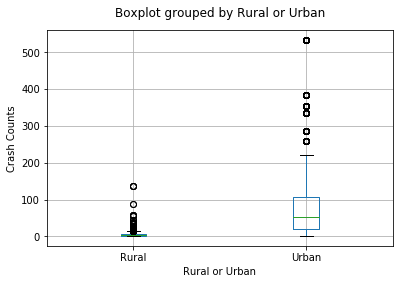

In [16]:
%matplotlib inline

# looking at the relationships between number of accidents and Rural/Urban roads
ax = df.boxplot(column='Crash Counts', by='Rural or Urban')
ax.set_ylabel('Crash Counts')
ax.set_title('')

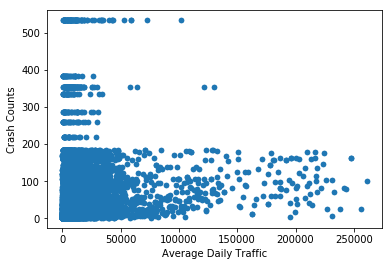

In [17]:
# looking at the relationship between number of crashes and average daily traffic
df.plot.scatter(x='Average Daily Traffic', y='Crash Counts')